In [9]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('paper')

In [2]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    #sim.add(m=Mp, P=2., e=0.1)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

In [11]:
Nout = 1000
e=0.1
dtOverT = 0.01
tmax = 10.
taua = 100.
times = np.linspace(0, tmax, Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)
psKD = simKD.particles
psKD[1].params['tau_a'] = -taua

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]

#rebxKD.add_operator(integforceKD, dt_fraction=0.5, timing="post")
rebxKD.add_operator(keplerKD, dt_fraction=1., timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")

simMDE = makesim(e=e, dtOverT=dtOverT)
simMDE.integrator = "none"
rebxMDE = reboundx.Extras(simMDE)
modMDE = rebxMDE.load_force("modify_orbits_forces")
rebxMDE.add_force(modMDE)

ias15 = rebxKD.load_operator("ias15")
keplerMDE = rebxMDE.load_operator("kepler")
integforceMDE = rebxMDE.load_operator("integrate_force")
integforceMDE.params['force'] = modMDE
integforceMDE.params['integrator'] = reboundx.integrators["rk4"]

rebxMDE.add_operator(ias15, dt_fraction=1., timing="pre")

rebxMDE.add_operator(integforceMDE, dt_fraction=-1./2., timing="post")
rebxMDE.add_operator(integforceMDE, dt_fraction=1./2., timing="pre")
#rebxMDE.add_operator(keplerMDE, dt_fraction=-1./np.sqrt(2.), timing="post")
#rebxMDE.add_operator(integforceMDE, dt_fraction=-1./np.sqrt(2.), timing="post")
#rebxMDE.add_operator(keplerMDE, dt_fraction=1./np.sqrt(2.), timing="post")
#rebxMDE.add_operator(integforceMDE, dt_fraction=1./np.sqrt(2.), timing="post")

psMDE = simMDE.particles
psMDE[1].params['tau_a'] = -taua

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)

ps = sim.particles
ps[1].params['tau_a'] = -taua

EsKD, EsMDE, Es = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
fKD, fMDE, f = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
P, e = np.zeros(Nout), np.zeros(Nout)
dEs, cumdEs = np.zeros(Nout), np.zeros(Nout)
E0 = simKD.calculate_energy()
for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    simMDE.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.t)
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    EsMDE[i] = simMDE.calculate_energy()
    fKD[i] = simKD.particles[1].f
    fMDE[i] = simMDE.particles[1].f
    f[i] = sim.particles[1].f
    P[i] = sim.particles[1].P
    e[i] = sim.particles[1].e
    
    '''
    tempsim = sim.copy()
    temprebx = reboundx.Extras(tempsim)
    tempkep = temprebx.load_operator("kepler")
    tempforce = temprebx.load_operator("integrate_force")
    tempmod = temprebx.load_force("modify_orbits_forces")
    tempforce.params['force'] = tempmod
    tempforce.params['integrator'] = reboundx.integrators["rk4"]
    tempsim.particles[1].params['tau_a'] = -taua

    tempforce.step(tempsim, -simKD.dt/np.sqrt(2.))
    tempkep.step(tempsim, -simKD.dt/np.sqrt(2.))
    tempforce.step(tempsim, simKD.dt/np.sqrt(2.))
    tempkep.step(tempsim, -simKD.dt/np.sqrt(2.))
    dEs[i] = tempsim.calculate_energy() - Es[i]
    
    try:
        cumdEs[i] = cumdEs[i-1] + dEs[i]
    except:
        cumdEs[i] = dEs[i]
    '''

Text(0.5,0,'Time (Orbits)')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


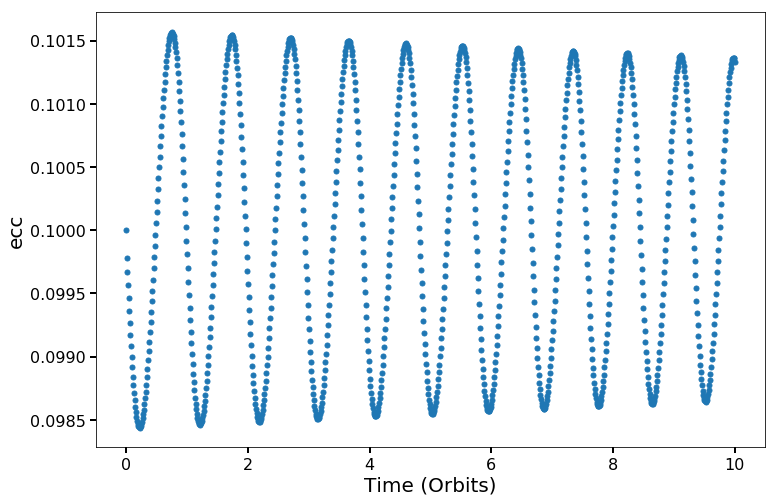

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, e, '.')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('ecc')
ax.set_xlabel('Time (Orbits)')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


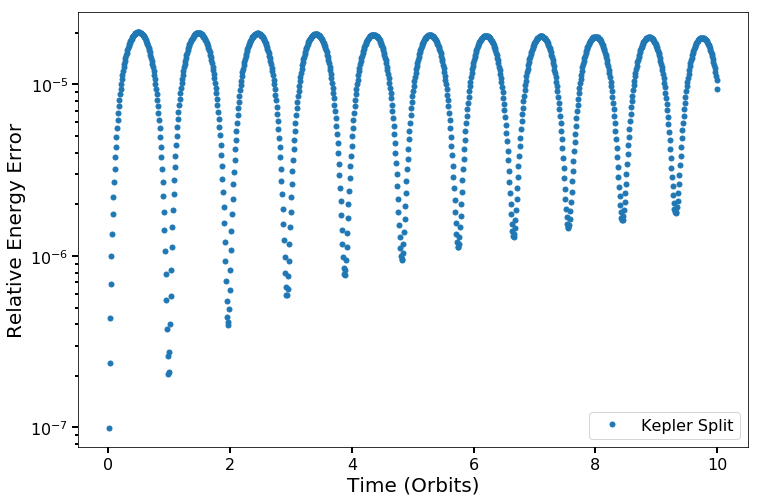

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


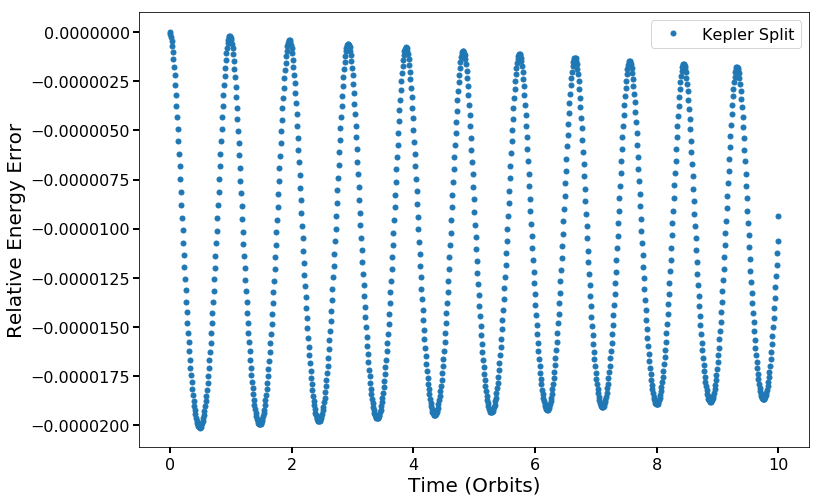

In [14]:
signedEerr = (EsKD-Es)/np.abs(Es)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, signedEerr, '.', label='Kepler Split')
#ax.plot(times, signedEerr[-1]*times/times[-1], 'm')
#ax.plot(times, -times/taua*sim.dt/taua/2/np.pi, 'm')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

#ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([-1e-5, -1e-3])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


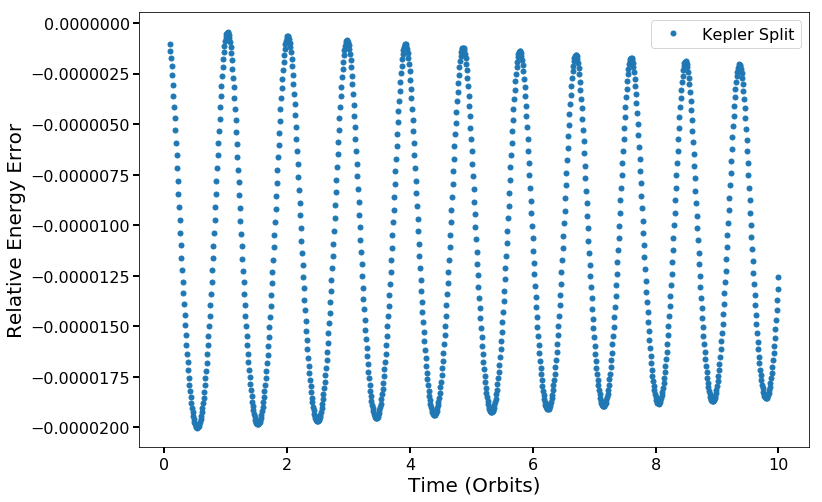

In [15]:
signedEerr = (EsKD-Es)/np.abs(Es)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, pd.Series(signedEerr).rolling(window=10).mean(), '.', label='Kepler Split')
#ax.plot(times, signedEerr[-1]*times/times[-1], 'm')
#ax.plot(times, -times/taua*sim.dt/taua/2/np.pi, 'm')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

#ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([-1e-5, -1e-3])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [201]:
sim.particles[1].e

0.09746785149371039

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


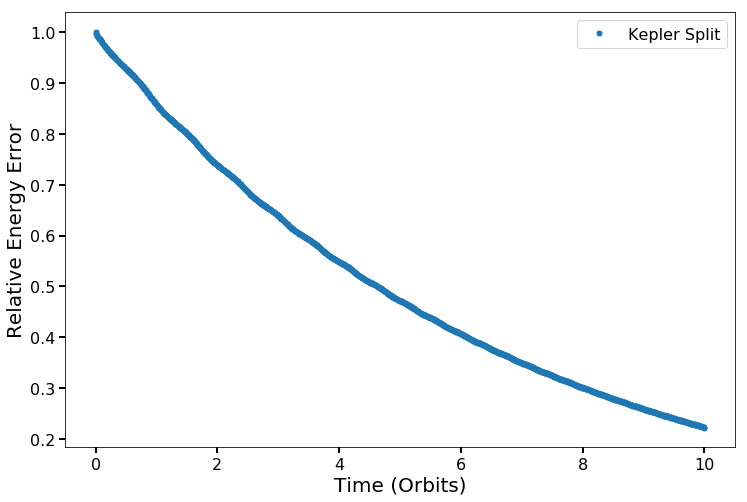

In [202]:
signedEerr = (EsKD-Es)/np.abs(Es)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, P, '.', label='Kepler Split')
#ax.plot(times, signedEerr[-1]*P[-1]/P, 'm')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

#ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([-1e-5, -1e-3])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

In [203]:
Es[-1]

-5.373754343120721e-07

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


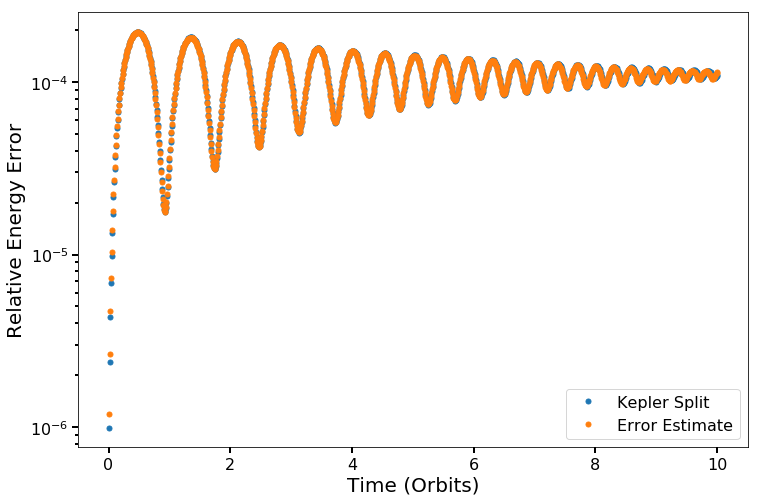

In [204]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Kepler Split')
ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

No handles with labels found to put in legend.


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


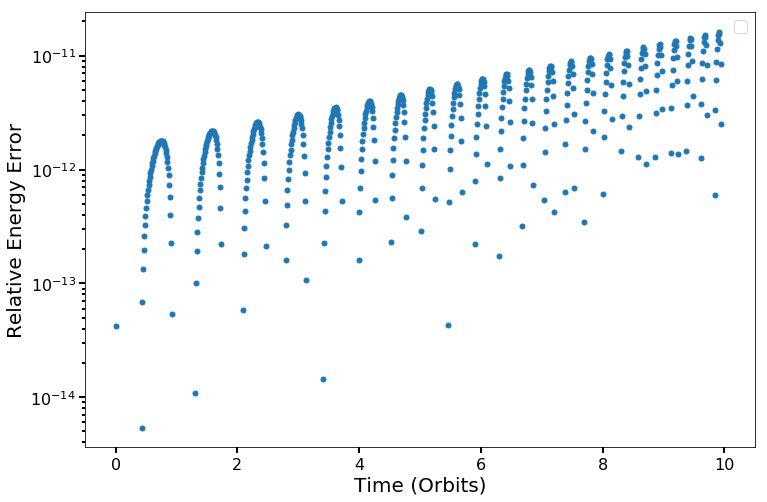

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, dEs, '.')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

No handles with labels found to put in legend.


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


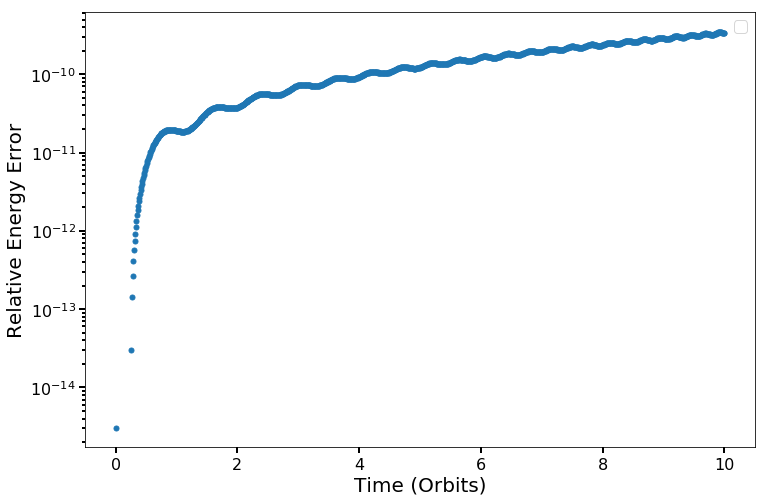

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, cumdEs, '.')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


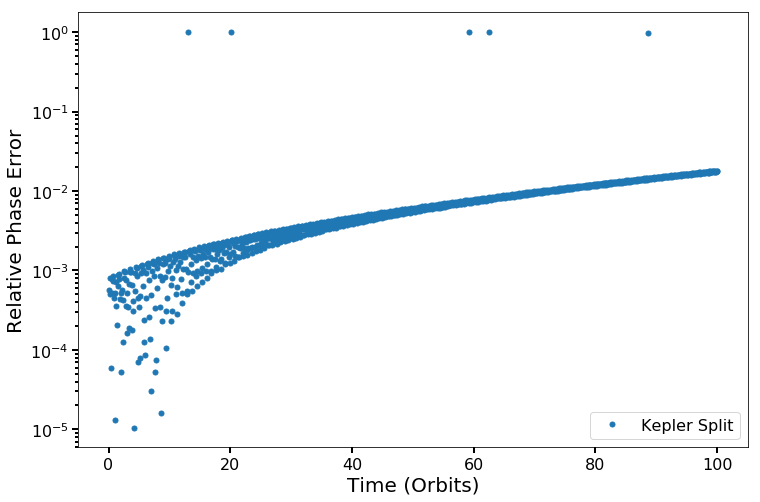

In [57]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((fKD-f)/2./np.pi), '.', label='Kepler Split')
#ax.plot(times, np.abs((EsMDE-Es)/Es), '.', label='Error Estimate')

ax.set_yscale('log')
#ax.plot(times, [(2*np.pi)/2.*dtOverT]*len(times), '--r')
ax.set_ylabel('Relative Phase Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-8, 1])
ax.legend()
#ax.plot(times, [(2*np.pi)**3/12.*e*J2*dtOverT**2]*len(times), '--r')

When we do KD, we are effectively doing a [K,D] post timestep after IAS15, so we damp first for a positive timestep, and undamp later. This means that the first time we damp -v/tau, v is higher and so we damp more, but the second time we go to undo it with +v/tau, v is lower, so we don't make it all back.

Also, we need to keep a fixed timestep for a splitting scheme to make any sense (since the ODEs it's solving depend on the timestep). If we integrate a damping system too long, then as the dynamical timescale approaches 10x the timestep or shorter (as say a planet migrates inward) then BCH no longer converges and you get lots of timestep resonances

Error at 0 ecc is second order in epsilon, because it's the difference between v at the two places giving you the difference. I think at ecc > epsilon, error comes from change in a giving you a phase error, and fact that you're on an eccentric orbit mattering where you are along orbit. Phase doesn't matter to energy error on a circular orbit.